## Machine Learning Summer School 2021 - Reinforcement Learning Workshop
# Assignment 2: [Deep Q Learning](https://arxiv.org/abs/1312.5602)

Welcome to DQN part of the workshop! :) Here you will be tasked with implementing the core logic behind the [famous paper by Mnih et al.](https://arxiv.org/abs/1312.5602) that has brought RL into the deep learning era. This notebook is divided into three main sections: 

1. **Problem description**: Where we introduce the Cartopole problem which we'll solve using the DQN paper.
2. **DQN implementation**: Where we explain our implementation of the DQN paper, and task you with comleting that implementation in two exercises.
3. **Experimentation**: Where we give notes on how to tune the DQN algorithm hyper-parameters and ask you to analyze results; and provide some closure notes.

**NOTE!**: Certain portion of the code is hidden, and only imported into this notebook. You can see full code base by clicking the Jupyter logo in the upper left corner.

## Problem description

We will test DQN on [The Cartpole Problem](https://gym.openai.com/envs/CartPole-v1/), where the pole is attached by an un-actuated joint to a cart which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the chart. The pendulum start upright, and the goal is to prevent it from falling over. A reward of +1 is provided from every tilmestep that the pole remains upright. The episode ends when the pole is more then 15 degrees from vertical, or the cart moves more then 2.4 from the center. At every time step, the agent observes its position, velocity, angle and angular velocity. These are the observable states of this world. At any state, the cart only has two possible actions: move to the left (0) and move to the right (+1). In other words, the state-space has four dimensions of continues values and the action space has one dimension of two discrete values.

Video below shows an **untrained agent** trying to solve this problem. Since it has not yet learned how to keep the pole upright, episodes quickly terminate when the pole surpasses the 15 degrees allowed limit, as described above.

![cartpole](resources/cartpole_env.mp4)

If the video above won't load properly, run the cell below to display the video.

In [1]:
import IPython
IPython.display.Video('./resources/cartpole_env.mp4', html_attributes="loop autoplay")

## DQN implementation

### Intro

[DQN](https://arxiv.org/abs/1312.5602) is the deep learning variant of the standard Q-Learning algorithm. Full pseudo-code for DQN is provided below:

1. Initialize replay memory (buffer) $D$ to capacity $N$
2. Initialize *live* action-value function neural network $Q$ with random weights.
3. Initialize *target* action-value function neural network $\hat{Q}$ by copying weights from the *live* one. 
4. **for** episode = $1$, $M$ **do**
    1. Restart episode and initialize start state $s_1$
    2. **for** t = $1$, $T$ **do**
        1. With probability $\varepsilon$ select random action $a_t$, otherwise <font color="green"> select $a_t = \max_aQ(s_t, a_t; \theta)$ </font>
        2. Execute selected action $a_t$ in the environment, and get $s_{t+1}$, $r_t$ and $\eta_{t+1}$, where $\eta_{t+1}$ indicates whether $s_{t+1}$ is a terminal state.
        3. Store *transition* $(s_j, a_j, s_{j+1}, r_j, \eta_{j+1})$ in replay memory (buffer) $D$.
        4. Sample mini-batch of transitions of size $h$ from replay memory $D$.
        5. <font color="green"> Calculate target value $y_j$ using the following rule: $y_j = r_j + (1 - \eta_{j+1})\gamma\max_{a'}\hat{Q}(s_{j+1}, a; \theta))$ </font>
        6. Calculate temoral difference error *TD Error*: $\delta = y_j - Q(s_j, a_j; \theta)$
        7. Regress the *live* network $Q$ with respect to $(\delta)^2$
    4. **end for**
5. **end for**

We would like to draw attention to the similarity of the DQN algorithm to standard Q-learning. In fact, if we were to use tabular representations of Q values, and remove the concepts of the *target* network and replay memory, the pseudo-code above would describe Q-learning instead. These additional concepts, however, are precisely the reason of DQN's success, and are the main focus of this exercise. <font color="green"> Green text specifies pseudo-code parts you are tasked with implementing. </font>

### Implementation

DQN implementation is divided into five cells. We encourage you to read through all cells, but to only modify those specified as **Exercise 1: Action selection** and **Exercise 2: Q-value update**. Throughout the rest of this section we explain the code and the reasoning behind it, and leave the exercises for you to complete :)

**NOTE!**: All cells need to be ran!

Run the cell below to import the required libraries. We use [PyTorch](https://pytorch.org) to implement the DQN algorithm, while [Gym](https://gym.openai.com) provides the Cartpole environment. File *nets.py* implements the neural networks that will be used in this tutorilal, while *utils.py* provides the neccessary utilities. You can see their contents (and full project structure in general) by clicking the Jupyter logo in the top left corner of the screen.

In [2]:
import os
import random
import torch
import time
import numpy as np
import gym

import torch.nn.functional as F

from env_wrapper import EnvWrapper
from nets import DQN
from utils import create_run_name, visualize_result
from rb import ReplayBuffer


import jdc


random.seed(0)
STORE_PATH = './tmp_deep_q_learning'

The next couple of cells implement the DQN agent we will use to solve the cartpole problem. In the cell below we define the DQN initialization procedure. **state_size**, **action_size**, **num_hidden**, **hidden_units** are used to construct the DQN neural networks the agent will use. **state_size** will define their input dimension, **action_size** will specify their output dimension, while **num_hidden** and **hidden_units** specify the number of hidden layers and the number of units in each, respectively.

The rest of the constructor arguments are some of the hyper-parameters of the algorithm you will be able to play around with. **gamma** ($\gamma$) represents the discount factor, **batch_size** represents the number of samples in mini-batch $h$, while **lr** is the learning rate of the optimizer.

In [3]:
class DQNAgent(object):
    def __init__(self, state_size, action_size, gamma=0.95, batch_size=256, lr=0.00025, num_hidden=2,
                 hidden_units=64):
        self.action_size = action_size
        self.state_size = state_size
        self.gamma = gamma
        self.name = 'DQN'

        # We create "live" and "target" networks from the original paper.
        self.current = DQN(state_size, action_size, h=hidden_units, num_hidden=num_hidden)
        self.target = DQN(state_size, action_size, h=hidden_units, num_hidden=num_hidden)
        for p in self.target.parameters():
            p.requires_grad = False
        self.update_target_model()

        # Replay buffer (memory) initialization.
        self.rb = self.init_rb()
        self.batch_size = batch_size

        # Learning rate and optimizer used to update the "live" network in DQN.
        learning_rate = lr
        self.optimizer = torch.optim.Adam(self.current.parameters(), lr=learning_rate)

The next cell specifies DQNAgent methods that deal with the replay memory and experience replay. **init_rb(self)** constructs the replay buffer $D$ which is used to store transitions. **remember(self, state, action, reward, next_state, done)** stores the transition $(s_j, a_j, s_{j+1}, r_j, \eta_{j+1})$ to the replay buffer, while **sample(self)** samples minibatch of size DQNAgent.batch_size ($h$) from it. If you want to check the specifics of our implementation of replay buffer, you can find it in [rb.py](../edit/rb.py).

In [4]:
%%add_to DQNAgent
def init_rb(self):
    # Replay buffer initialization.
    replay_buffer = ReplayBuffer(1e5, obs_dtype=np.float32, act_dtype=np.int64, default_dtype=np.float32)
    return replay_buffer

def remember(self, state, action, reward, next_state, done):
    # Remember (Q,S,A,R,S') as well as whether S' is terminating state.
    self.rb.add(obs=state, act=action, rew=reward, next_obs=next_state, done=done)

def sample(self):
    states, actions, next_states, rewards, dones = self.rb.sample(self.batch_size)
    one_hot_acts = torch.squeeze(
        torch.nn.functional.one_hot(actions, num_classes=self.action_size))
    return states, one_hot_acts, rewards, next_states, dones

DQN paper introduces the *target* network $\hat{Q}$ which is used to estimate optimal Q-values when calculating the TD error $\delta$. Target network differs from the *live* one in that it does not update its parameters $\theta$ as frequently. This produces more stable Q-value estimates, and is aimed at stabilizing the training process by giving the *live* network necessary time to converge across multiple mini-batches, before the *target* network is finally updated. 

There are multiple ways we can orchestrate theese periodic updates. The original DQN paper simply copies the weights of the *live* network every $K$ episodes to the *traget* network, which we adopt here as well and implement in **update_target_model(self)** below.

In [5]:
%%add_to DQNAgent
def update_target_model(self):
    self.target.load_state_dict(self.current.state_dict())

#### Exercise 1: Action selection

Complete the function **select_action(self, state)** below to greedily select best actions using the current estimate of the Q-values. **We strongly encourage you to read through the rest of the code explanations before starting the exercise.** This exercise corresponds to <font color="green"> pseudo-code algorithm step 4.B.a</font>.


In [6]:
%%add_to DQNAgent
def select_action(self, state):
    # ######## TODO: IMPLEMENT DQN ACTION SELECTION HERE ########
    # Hint 1: DQN uses the same greedy policy as regular Q-Learning
    # Hint 2: We want to select purely greedy action here, random action selection
    # based on epsilon is already handled
    action = self.current(state).argmax().item()

    
    return action

#### Exercise 2: Q-value update

Complete the function **backward(self)** below to update current estimates of Q-values. **We strongly encourage you to read through the rest of the code explanations before starting the exercise.** This exercise corresponds to pseudo-code algorithm step <font color="green"> pseudo-code algorithm step 4.B.e</font>.

In [7]:
%%add_to DQNAgent
def backward(self):
    # ######## TODO: IMPLEMENT DQN UPDATE STEP HERE ########
    # # 1. Sample mini-batch of stored transitions from the replay buffer
    states, one_hot_acts, rewards, next_states, dones = self.sample()


    # # 2. Implement the learning part of the DQN algorithm.
    # ### a. Use "states" (batch_dim x self.state_size) and "actions" (batch_dim x action_size)
    #     to get Q values (batch_dim x 1) of actions agent had played out in the environment.
    #     USE qs_selected VARIABLE TO STORE RESULT!
    qs_selected = (self.current(states) * one_hot_acts).sum(axis=1)



    # ### b. Use "next_states" (batch_dim x self.state_size) to calculate the target value
    #     Q values obtained in a. should be regressed to.
    #     Hint 1: Target network plays important part here!
    #     Hint 2: Pay attention to PyTorch gradient accumulation!
    #     Hint 3: You can use "dones" (batch_dim x 1) to check whether "next_states" are
    #     terminating!
    #     USE qs_target VARIABLE TO STORE RESULT!
    
#     print(rewards.shape)
#     print(dones.shape)
#     print(next_states.shape)
#     print(self.batch_size)
#     print(self.target(next_states).shape)
    
#     print("ALIVE")
    
    with torch.no_grad():
#         calc1 = 1 - dones.int()
#         print("CALC 1")
#         calc2 = GAMMA * calc1
#         print("CALC 2")
#         calc3 = self.target(next_states)
#         print("CALC 3")
#         calc4 = calc3.max(axis=1)
#         print("CALC 4")
#         print(calc2.shape, calc4.shape)
#         calc5 = calc2 * calc4
#         print("CALC 5")
#         qs_target = rewards - calc5
        qs_target = rewards - (1 - dones.int()) * GAMMA * self.target(next_states).max(axis=1)[0]

#     print("ALIVE")

    

    # Code below updates the "live" network self.current using the variables you have
    # calculated in TODO section above: qs_selected and qs_target. DO NOT MODIFY THIS CODE.

    # We calculate the absolute difference between current and target values q values,
    # which is useful info for debugging.
    with torch.no_grad():
        td_error = torch.abs(qs_target - qs_selected)

    # We update the "live" network, self.current. First we zero out the optimizer gradients
    # and then we apply the update step using qs_selected and qs_target.
    self.optimizer.zero_grad()
    loss = (torch.nn.functional.mse_loss(qs_selected, qs_target)).mean()
    loss.backward()
    self.optimizer.step()
    return torch.mean(td_error).item()

The cell below contains all of the tunable hyper-parameters of the DQNAgent. Once you have a working implementation of the two exercises above, you can tune these hyper-parameters and see how they affect the training process.

In [8]:
# ### HYPER PARAMETERS ##########
# ### EPISODE ###################
# Number of episodes to train for
EPISODES = 250
# Number of steps per episode
STEPS = 200

# ### TRAINING ##################
# Start exploration rate
# for eps greedy policy
EPSILON_START = 1
# End exploration rate
EPSILON_END = 0.001
# Exploration rate decay
# per EPISODE
EPSILON_DECAY = 0.985
# Discount rate
GAMMA = 0.95
# DQN Target network update
# frequency in EPISODES
TARGET_FREQ = 4
# DQN live network update
# frequency in STEPS
UPDATE_FREQ = 1
# Learning rate
LR = 0.00015
# Batch size
BATCH_SIZE = 256

# ### NETWORK ARCHITECTURE ######
# Number of hidden layers
# of H units
NUM_H = 2
# Number of units in hidden
# layers
H = 64
# ### HYPER PARAMETERS END #######
run_name = create_run_name(
        alg='DQN',
        env='stick',
        num_layers=NUM_H,
        hidden_dim=H,
        eps_start=EPSILON_START,
        eps_end=EPSILON_END,
        decay=EPSILON_DECAY,
        gamma=GAMMA,
        batch_size=BATCH_SIZE,
        lr=LR,
        num_ep=EPISODES,
        num_step=STEPS,
        updt_freq=UPDATE_FREQ,
        sw_freq=TARGET_FREQ
    )

The code in the cell below encapsulates the DQNAgent and controls its training process according to the algorithm presented in the introductiory section. We start with constructing the environment **env**, and the DQNAgent itself. We then continue with the implementation of the overall DQN algorithm from the introductory section.

We copy the algorithm below, for your ease of reference:

1. Initialize replay memory (buffer) $D$ to capacity $N$
2. Initialize *live* action-value function neural network $Q$ with random weights.
3. Initialize *target* action-value function neural network $\hat{Q}$ by copying weights from the *live* one. 
4. **for** episode = $1$, $M$ **do**
    1. Restart episode and initialize start state $s_1$
    2. **for** t = $1$, $T$ **do**
        1. With probability $\varepsilon$ select random action $a_t$, otherwise <font color="green"> select $a_t = \max_aQ(s_t, a_t; \theta)$ </font>
        2. Execute selected action $a_t$ in the environment, and get $s_{t+1}$, $r_t$ and $\eta_{t+1}$, where $\eta_{t+1}$ indicates whether $s_{t+1}$ is a terminal state.
        3. Store *transition* $(s_j, a_j, s_{j+1}, r_j, \eta_{j+1})$ in replay memory (buffer) $D$.
        4. Sample mini-batch of transitions of size $h$ from replay memory $D$.
        5. <font color="green"> Calculate target value $y_j$ using the following rule: $y_j = r_j + (1 - \eta_{j+1})\gamma\max_{a'}\hat{Q}(s_{j+1}, a; \theta))$ </font>
        6. Calculate temoral difference error *TD Error*: $\delta = y_j - Q(s_j, a_j; \theta)$
        7. Regress the *live* network $Q$ with respect to $(\delta)^2$
    4. **end for**
5. **end for**

We encourage you to find each pseudo-code step in the implementation below before starting with the exercises. Finally, when you complete both of the exercises, run this cell to start the training process!

**NOTE!**: Remember to run all previous cells. The final output of the cell below will be a figure displaing returns (rewards obtained throughout episodes), and TD Errors per each step when DQN agent was updated (each backward() pass). You can review theese figures by clicking on Jupyter logo in top left corner, and navigating to **tmp_deep_q_learning** folder, where figures are stored and named based on the algorithm hyper-parameters that have generated them.

EPISODE: 1   / 250 | EXPLORE RATE: 1.0000  | SCORE: 47.0    | WARMUP - NO TD ERROR
EPISODE: 2   / 250 | EXPLORE RATE: 0.9850  | SCORE: 16.0    | WARMUP - NO TD ERROR
EPISODE: 3   / 250 | EXPLORE RATE: 0.9702  | SCORE: 16.0    | WARMUP - NO TD ERROR
EPISODE: 4   / 250 | EXPLORE RATE: 0.9557  | SCORE: 30.0    | WARMUP - NO TD ERROR
EPISODE: 5   / 250 | EXPLORE RATE: 0.9413  | SCORE: 14.0    | WARMUP - NO TD ERROR
EPISODE: 6   / 250 | EXPLORE RATE: 0.9272  | SCORE: 10.0    | WARMUP - NO TD ERROR
EPISODE: 7   / 250 | EXPLORE RATE: 0.9133  | SCORE: 15.0    | WARMUP - NO TD ERROR
EPISODE: 8   / 250 | EXPLORE RATE: 0.8996  | SCORE: 19.0    | WARMUP - NO TD ERROR
EPISODE: 9   / 250 | EXPLORE RATE: 0.8861  | SCORE: 17.0    | WARMUP - NO TD ERROR
EPISODE: 10  / 250 | EXPLORE RATE: 0.8728  | SCORE: 15.0    | WARMUP - NO TD ERROR
EPISODE: 11  / 250 | EXPLORE RATE: 0.8597  | SCORE: 10.0    | WARMUP - NO TD ERROR
EPISODE: 12  / 250 | EXPLORE RATE: 0.8468  | SCORE: 27.0    | TD ERROR: 0.93  
EPISODE:

<string>:61: UserWarning: Using a target size (torch.Size([256, 256])) that is different to the input size (torch.Size([256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


EPISODE: 14  / 250 | EXPLORE RATE: 0.8216  | SCORE: 14.0    | TD ERROR: 0.78  
EPISODE: 15  / 250 | EXPLORE RATE: 0.8093  | SCORE: 15.0    | TD ERROR: 0.73  
EPISODE: 16  / 250 | EXPLORE RATE: 0.7972  | SCORE: 17.0    | TD ERROR: 0.64  
EPISODE: 17  / 250 | EXPLORE RATE: 0.7852  | SCORE: 40.0    | TD ERROR: 0.29  
EPISODE: 18  / 250 | EXPLORE RATE: 0.7734  | SCORE: 20.0    | TD ERROR: 0.23  
EPISODE: 19  / 250 | EXPLORE RATE: 0.7618  | SCORE: 23.0    | TD ERROR: 0.20  
EPISODE: 20  / 250 | EXPLORE RATE: 0.7504  | SCORE: 25.0    | TD ERROR: 0.15  
EPISODE: 21  / 250 | EXPLORE RATE: 0.7391  | SCORE: 19.0    | TD ERROR: 0.20  
EPISODE: 22  / 250 | EXPLORE RATE: 0.7280  | SCORE: 18.0    | TD ERROR: 0.13  
EPISODE: 23  / 250 | EXPLORE RATE: 0.7171  | SCORE: 25.0    | TD ERROR: 0.11  
EPISODE: 24  / 250 | EXPLORE RATE: 0.7064  | SCORE: 57.0    | TD ERROR: 0.09  
EPISODE: 25  / 250 | EXPLORE RATE: 0.6958  | SCORE: 34.0    | TD ERROR: 0.10  
EPISODE: 26  / 250 | EXPLORE RATE: 0.6853  | SCORE: 

EPISODE: 120 / 250 | EXPLORE RATE: 0.1655  | SCORE: 39.0    | TD ERROR: 0.04  
EPISODE: 121 / 250 | EXPLORE RATE: 0.1631  | SCORE: 74.0    | TD ERROR: 0.04  
EPISODE: 122 / 250 | EXPLORE RATE: 0.1606  | SCORE: 31.0    | TD ERROR: 0.03  
EPISODE: 123 / 250 | EXPLORE RATE: 0.1582  | SCORE: 20.0    | TD ERROR: 0.04  
EPISODE: 124 / 250 | EXPLORE RATE: 0.1558  | SCORE: 30.0    | TD ERROR: 0.03  
EPISODE: 125 / 250 | EXPLORE RATE: 0.1535  | SCORE: 24.0    | TD ERROR: 0.04  
EPISODE: 126 / 250 | EXPLORE RATE: 0.1512  | SCORE: 10.0    | TD ERROR: 0.04  
EPISODE: 127 / 250 | EXPLORE RATE: 0.1489  | SCORE: 62.0    | TD ERROR: 0.03  
EPISODE: 128 / 250 | EXPLORE RATE: 0.1467  | SCORE: 42.0    | TD ERROR: 0.04  
EPISODE: 129 / 250 | EXPLORE RATE: 0.1445  | SCORE: 64.0    | TD ERROR: 0.03  
EPISODE: 130 / 250 | EXPLORE RATE: 0.1423  | SCORE: 44.0    | TD ERROR: 0.04  
EPISODE: 131 / 250 | EXPLORE RATE: 0.1402  | SCORE: 50.0    | TD ERROR: 0.04  
EPISODE: 132 / 250 | EXPLORE RATE: 0.1381  | SCORE: 

EPISODE: 225 / 250 | EXPLORE RATE: 0.0339  | SCORE: 29.0    | TD ERROR: 0.03  
EPISODE: 226 / 250 | EXPLORE RATE: 0.0334  | SCORE: 15.0    | TD ERROR: 0.03  
EPISODE: 227 / 250 | EXPLORE RATE: 0.0329  | SCORE: 16.0    | TD ERROR: 0.03  
EPISODE: 228 / 250 | EXPLORE RATE: 0.0324  | SCORE: 25.0    | TD ERROR: 0.04  
EPISODE: 229 / 250 | EXPLORE RATE: 0.0319  | SCORE: 15.0    | TD ERROR: 0.03  
EPISODE: 230 / 250 | EXPLORE RATE: 0.0314  | SCORE: 8.0     | TD ERROR: 0.03  
EPISODE: 231 / 250 | EXPLORE RATE: 0.0309  | SCORE: 87.0    | TD ERROR: 0.03  
EPISODE: 232 / 250 | EXPLORE RATE: 0.0305  | SCORE: 39.0    | TD ERROR: 0.03  
EPISODE: 233 / 250 | EXPLORE RATE: 0.0300  | SCORE: 41.0    | TD ERROR: 0.03  
EPISODE: 234 / 250 | EXPLORE RATE: 0.0296  | SCORE: 41.0    | TD ERROR: 0.03  
EPISODE: 235 / 250 | EXPLORE RATE: 0.0291  | SCORE: 13.0    | TD ERROR: 0.03  
EPISODE: 236 / 250 | EXPLORE RATE: 0.0287  | SCORE: 29.0    | TD ERROR: 0.04  
EPISODE: 237 / 250 | EXPLORE RATE: 0.0282  | SCORE: 

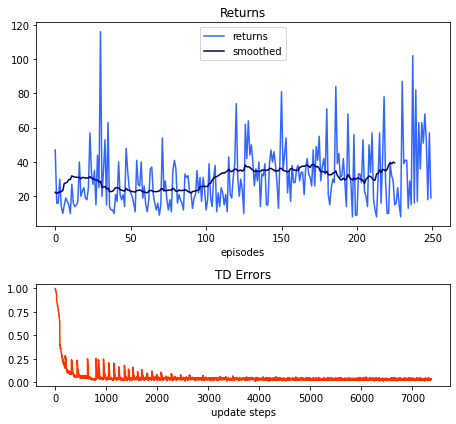

In [9]:
env = EnvWrapper(gym_env=gym.make('CartPole-v0'), steps=STEPS)
# Initialize Q networks, replay memory
agent = DQNAgent(
    state_size=env.state_size(),
    action_size=env.action_size(),
    gamma=GAMMA,
    batch_size=BATCH_SIZE,
    lr=LR,
    num_hidden=NUM_H,
    hidden_units=H
)

epsilon = EPSILON_START
results = []
td_errors = []
start = time.time()
random.seed(0)

for episode in range(EPISODES):
    # Start game/episode
    state = env.reset()
    cum_rew = 0

    if episode > 10 and episode % TARGET_FREQ == 0:
        agent.update_target_model()

    # Loop inside one game episode
    for t in range(STEPS):
        
        # Display the game. Comment bellow line in order to get faster training.
#         env.render()
        
        if random.random() <= epsilon:
            action = env.env.action_space.sample()
        else:
            # ########## EXERCISE 1: ACTION SELECTION ##########################
            action = agent.select_action(state=torch.from_numpy(state).detach())
            # ##################################################################

        next_state, reward, done = env.step(action)
        cum_rew += reward
        
        # Store transition to replay memory
        agent.remember(state=state, action=action, reward=reward, next_state=next_state, done=float(done))
        
        # Update Q-values
        if episode > 10 and (episode + t) % UPDATE_FREQ == 0:
            # ## EXERCISE 2: Q-VALUE UPDATE ##
            td_error = agent.backward()
            # ################################
            td_errors.append(td_error)

        if done or (t == STEPS - 1):
            if episode > 10:
                print("EPISODE: {0: <4}/{1: >4} | EXPLORE RATE: {2: <7.4f} | SCORE: {3: <7.1f}"
                      " | TD ERROR: {4: <5.2f} ".format(episode + 1, EPISODES, epsilon, cum_rew, td_error))
            else:
                print("EPISODE: {0: <4}/{1: >4} | EXPLORE RATE: {2: <7.4f} | SCORE: {3: <7.1f}"
                      " | WARMUP - NO TD ERROR".format(episode + 1, EPISODES, epsilon, cum_rew))
            results.append(cum_rew)
            break

        state = next_state

    if epsilon > EPSILON_END:
        epsilon *= EPSILON_DECAY

end = time.time()
total_time = end - start

print()
print("TOTAL EPISODES: {0: <4} | TOTAL UPDATE STEPS: {1: <7} | TOTAL TIME [s]: {2: <7.2f}"
      .format(EPISODES, len(td_errors), total_time))
print("EP PER SECOND: {0: >10.6f}".format(total_time / EPISODES))
print("STEP PER SECOND: {0: >8.6f}".format(total_time / len(td_errors)))

fig = visualize_result(
    returns=results,
    td_errors=td_errors,
    policy_errors=None
)
fig.savefig(os.path.join(STORE_PATH, run_name + '.png'), dpi=400)

## Experimentation

The end goal of this exercise is for you to get the feel of applying RL concepts in practice. To that effect, try to figure out an answer to questions below:

1. Which hyper-parameters affect training stability and why?
2. Which hyper-parameters affect the potential to obtain high rewards?
3. What is the reasonable scale of TD error in this particular problem?


Finally,you can try to solve other problems using DQNs, provided they have discrete action space. You can find additional pre-made environments on the [OpenAI Gym website](https://gym.openai.com/envs/#classic_control). If you wish to try this notebook on other problems, simply substitute the environment name on line 1 of the cell above with the new one. (e.g. **CartPole-v0** -> **MountainCar-v0**)

Additionally, we provide a couple of resources for further study:

* Stability of the DQN algorithm is analyzed in greater detail by [Roderick et al.: Implementing the Deep Q-Network](https://arxiv.org/abs/1711.07478). You can find the original DQN paper by Mnih et al. [here](https://arxiv.org/abs/1312.5602). Finally, if you are interested in further study into DQNs, we recommend two additional papers: [Deep Reinforcement Learning with Double Q-learning](https://arxiv.org/abs/1509.06461) by Hasselt et al, and [Dueling Network Architectures for Deep Reinforcement Learning](https://arxiv.org/abs/1511.06581) by Wang et al. Many of the open-source DQN implementations actually use both of these papers to further improve the base algorithm!
* Couple of open-source implementations of DQN (and other algorithms!) are: [Baselines](https://github.com/openai/baselines), [Spinning Up](https://github.com/openai/spinningup), [rllab](https://github.com/rll/rllab). 
* A great blog to read about various RL (and ML) papers: [Lil'Log](https://lilianweng.github.io/lil-log/).